In [1]:
import sys
import genlib

In [3]:
npop = 50
evo = genlib.Evolution(npop, npcs=13, mut_threshold=0.01, instance=0)
evo.darwinize()

- check rotation, mirroring
- add checkers

/home/mlubej/.pyenv/versions/3.7.6/envs/play/lib/python3.7/site-packages/shapely/affinity.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if origin == 'center':
/home/mlubej/.pyenv/versions/3.7.6/envs/play/lib/python3.7/site-packages/shapely/affinity.py:112: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif origin == 'centroid':


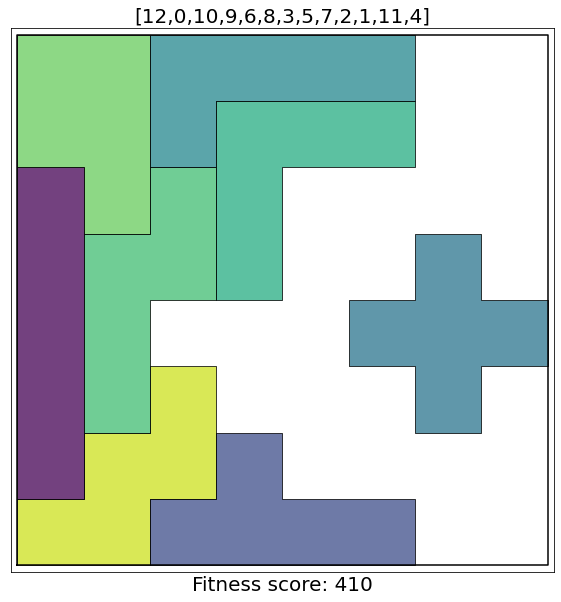

In [9]:
ind = genlib.Individual([12,0,10,9,6,8,3,5,7,2,1,11,4])
ind.plot()